# PS reconstruction slice emittance example

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quadlet_tdc_bend
from phase_space_reconstruction.virtual.scans import run_awa_3d_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.visualization import plot_3d_scan_data
from phase_space_reconstruction.train import train_3d_scan, train_3d_scan_parallel_gpus

from bmadx.distgen_utils import create_beam
from bmadx.plot import plot_projections
from bmadx.constants import PI

## Create synthetic ground truth beam

In [2]:
gt_beam = torch.load("data/eex_beam.pt")
save_dir = "data/eex_beam"
p0c = gt_beam.p0c

## Define diagnostics lattice parameters

In [3]:
# triplet params obtained from triplet-opt.ipynb
#k1 =    13.733624
#k2 =  -23.473085
#k3 =   24.013177
#k1  =            -8.760911
#k2  =            24.620257
#k3  =            -29.52607
k1  =           -21.817185
k2  =           -30.131326
k3  =            25.199412

In [4]:
# diagnostic beamline:
lattice = quadlet_tdc_bend(p0c=p0c, dipole_on=False)
lattice.elements[0].K1.data = torch.tensor(k1)
lattice.elements[2].K1.data = torch.tensor(k2)
lattice.elements[4].K1.data = torch.tensor(k3)

# Scan over quad strength, tdc on/off and dipole on/off
scan_ids = [6, 8, 10] 
n_ks = 5
ks = torch.linspace(-1, 1, n_ks) # quad ks
vs = torch.tensor([0, 1.0e6])#5e6]) # TDC off/on
gs = torch.tensor([-2.22e-16, -20.0*PI/180.0/0.365]) # dipole off/on
train_params = torch.stack(torch.meshgrid(ks, vs, gs, indexing='ij'))
print(train_params.shape)
print(train_params.unsqueeze(-1).shape)

# create diagnostic screen: 
bins = torch.linspace(-7, 7, 200) * 1e-3
bandwidth = (bins[1]-bins[0]) / 2
screen = ImageDiagnostic(bins, bins, bandwidth)

torch.Size([3, 5, 2, 2])
torch.Size([3, 5, 2, 2, 1])


/global/u1/r/rroussel/phase_space_reconstruction/phase_space_reconstruction/virtual/beamlines.py:318: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  P0C=torch.tensor(p0c),


## Complete 3D scan training data

In [5]:
# generate and save train and test datasets
train_dset_3d_scan = run_awa_3d_scan(
    gt_beam, 
    lattice,
    screen, 
    ks, vs, gs,
    ids = scan_ids,
#    save_as = '3d_scan_train.dset'
)

print(train_dset_3d_scan.params.shape)
print(train_dset_3d_scan.images.shape)

torch.Size([20, 3, 1])
torch.Size([20, 1, 200, 200])


torch.Size([200, 200])


/global/homes/r/rroussel/.conda/envs/ps-reconstruction/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1694463969407/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


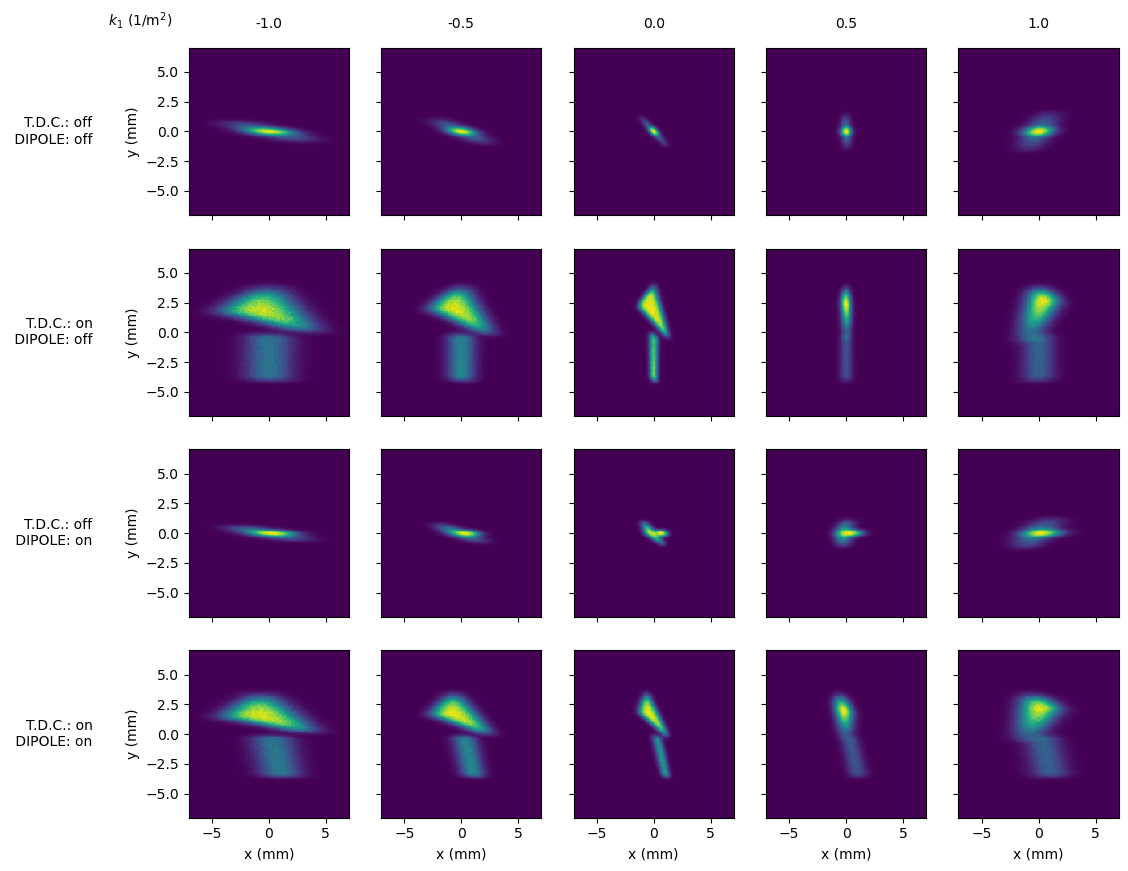

In [6]:
fig, ax = plot_3d_scan_data(train_dset_3d_scan, bins)
plt.show()

In [7]:
fig.savefig("eex_data.svg",dpi=300)

### 10,000 particles, multi-GPU

In [26]:
%%time
import torch

pred_beam_3d_scan_10_000 = train_3d_scan(
    train_dset_3d_scan,
    lattice,
    p0c,
    screen,
    ids = scan_ids,
    n_epochs = 3_000, 
    n_particles = 100_000, 
    device = 'cuda:0',
    save_dir = save_dir,
    distribution_dump_frequency=200,
    distribution_dump_n_particles=1_000_000,
    use_decay=False
    
)

Using device: cuda:0


/global/u1/r/rroussel/phase_space_reconstruction/phase_space_reconstruction/train.py:366: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p0c=torch.tensor(p0c),


0 tensor(4.6578e-05, device='cuda:0', grad_fn=<MeanBackward0>)


/global/u1/r/rroussel/phase_space_reconstruction/phase_space_reconstruction/train.py:397: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distribution_dump_n_particles, p0c=torch.tensor(p0c)


100 tensor(3.9252e-06, device='cuda:0', grad_fn=<MeanBackward0>)
200 tensor(3.3174e-06, device='cuda:0', grad_fn=<MeanBackward0>)
300 tensor(2.8882e-06, device='cuda:0', grad_fn=<MeanBackward0>)
400 tensor(2.2954e-06, device='cuda:0', grad_fn=<MeanBackward0>)
500 tensor(2.1587e-06, device='cuda:0', grad_fn=<MeanBackward0>)
600 tensor(2.6872e-06, device='cuda:0', grad_fn=<MeanBackward0>)
700 tensor(2.3984e-06, device='cuda:0', grad_fn=<MeanBackward0>)
800 tensor(2.5780e-06, device='cuda:0', grad_fn=<MeanBackward0>)
900 tensor(2.5623e-06, device='cuda:0', grad_fn=<MeanBackward0>)
1000 tensor(2.2460e-06, device='cuda:0', grad_fn=<MeanBackward0>)
1100 tensor(2.1512e-06, device='cuda:0', grad_fn=<MeanBackward0>)
1200 tensor(2.6831e-06, device='cuda:0', grad_fn=<MeanBackward0>)
1300 tensor(2.0948e-06, device='cuda:0', grad_fn=<MeanBackward0>)
1400 tensor(1.9707e-06, device='cuda:0', grad_fn=<MeanBackward0>)
1500 tensor(1.9803e-06, device='cuda:0', grad_fn=<MeanBackward0>)
1600 tensor(2.5215e

In [9]:
torch.cuda.empty_cache()

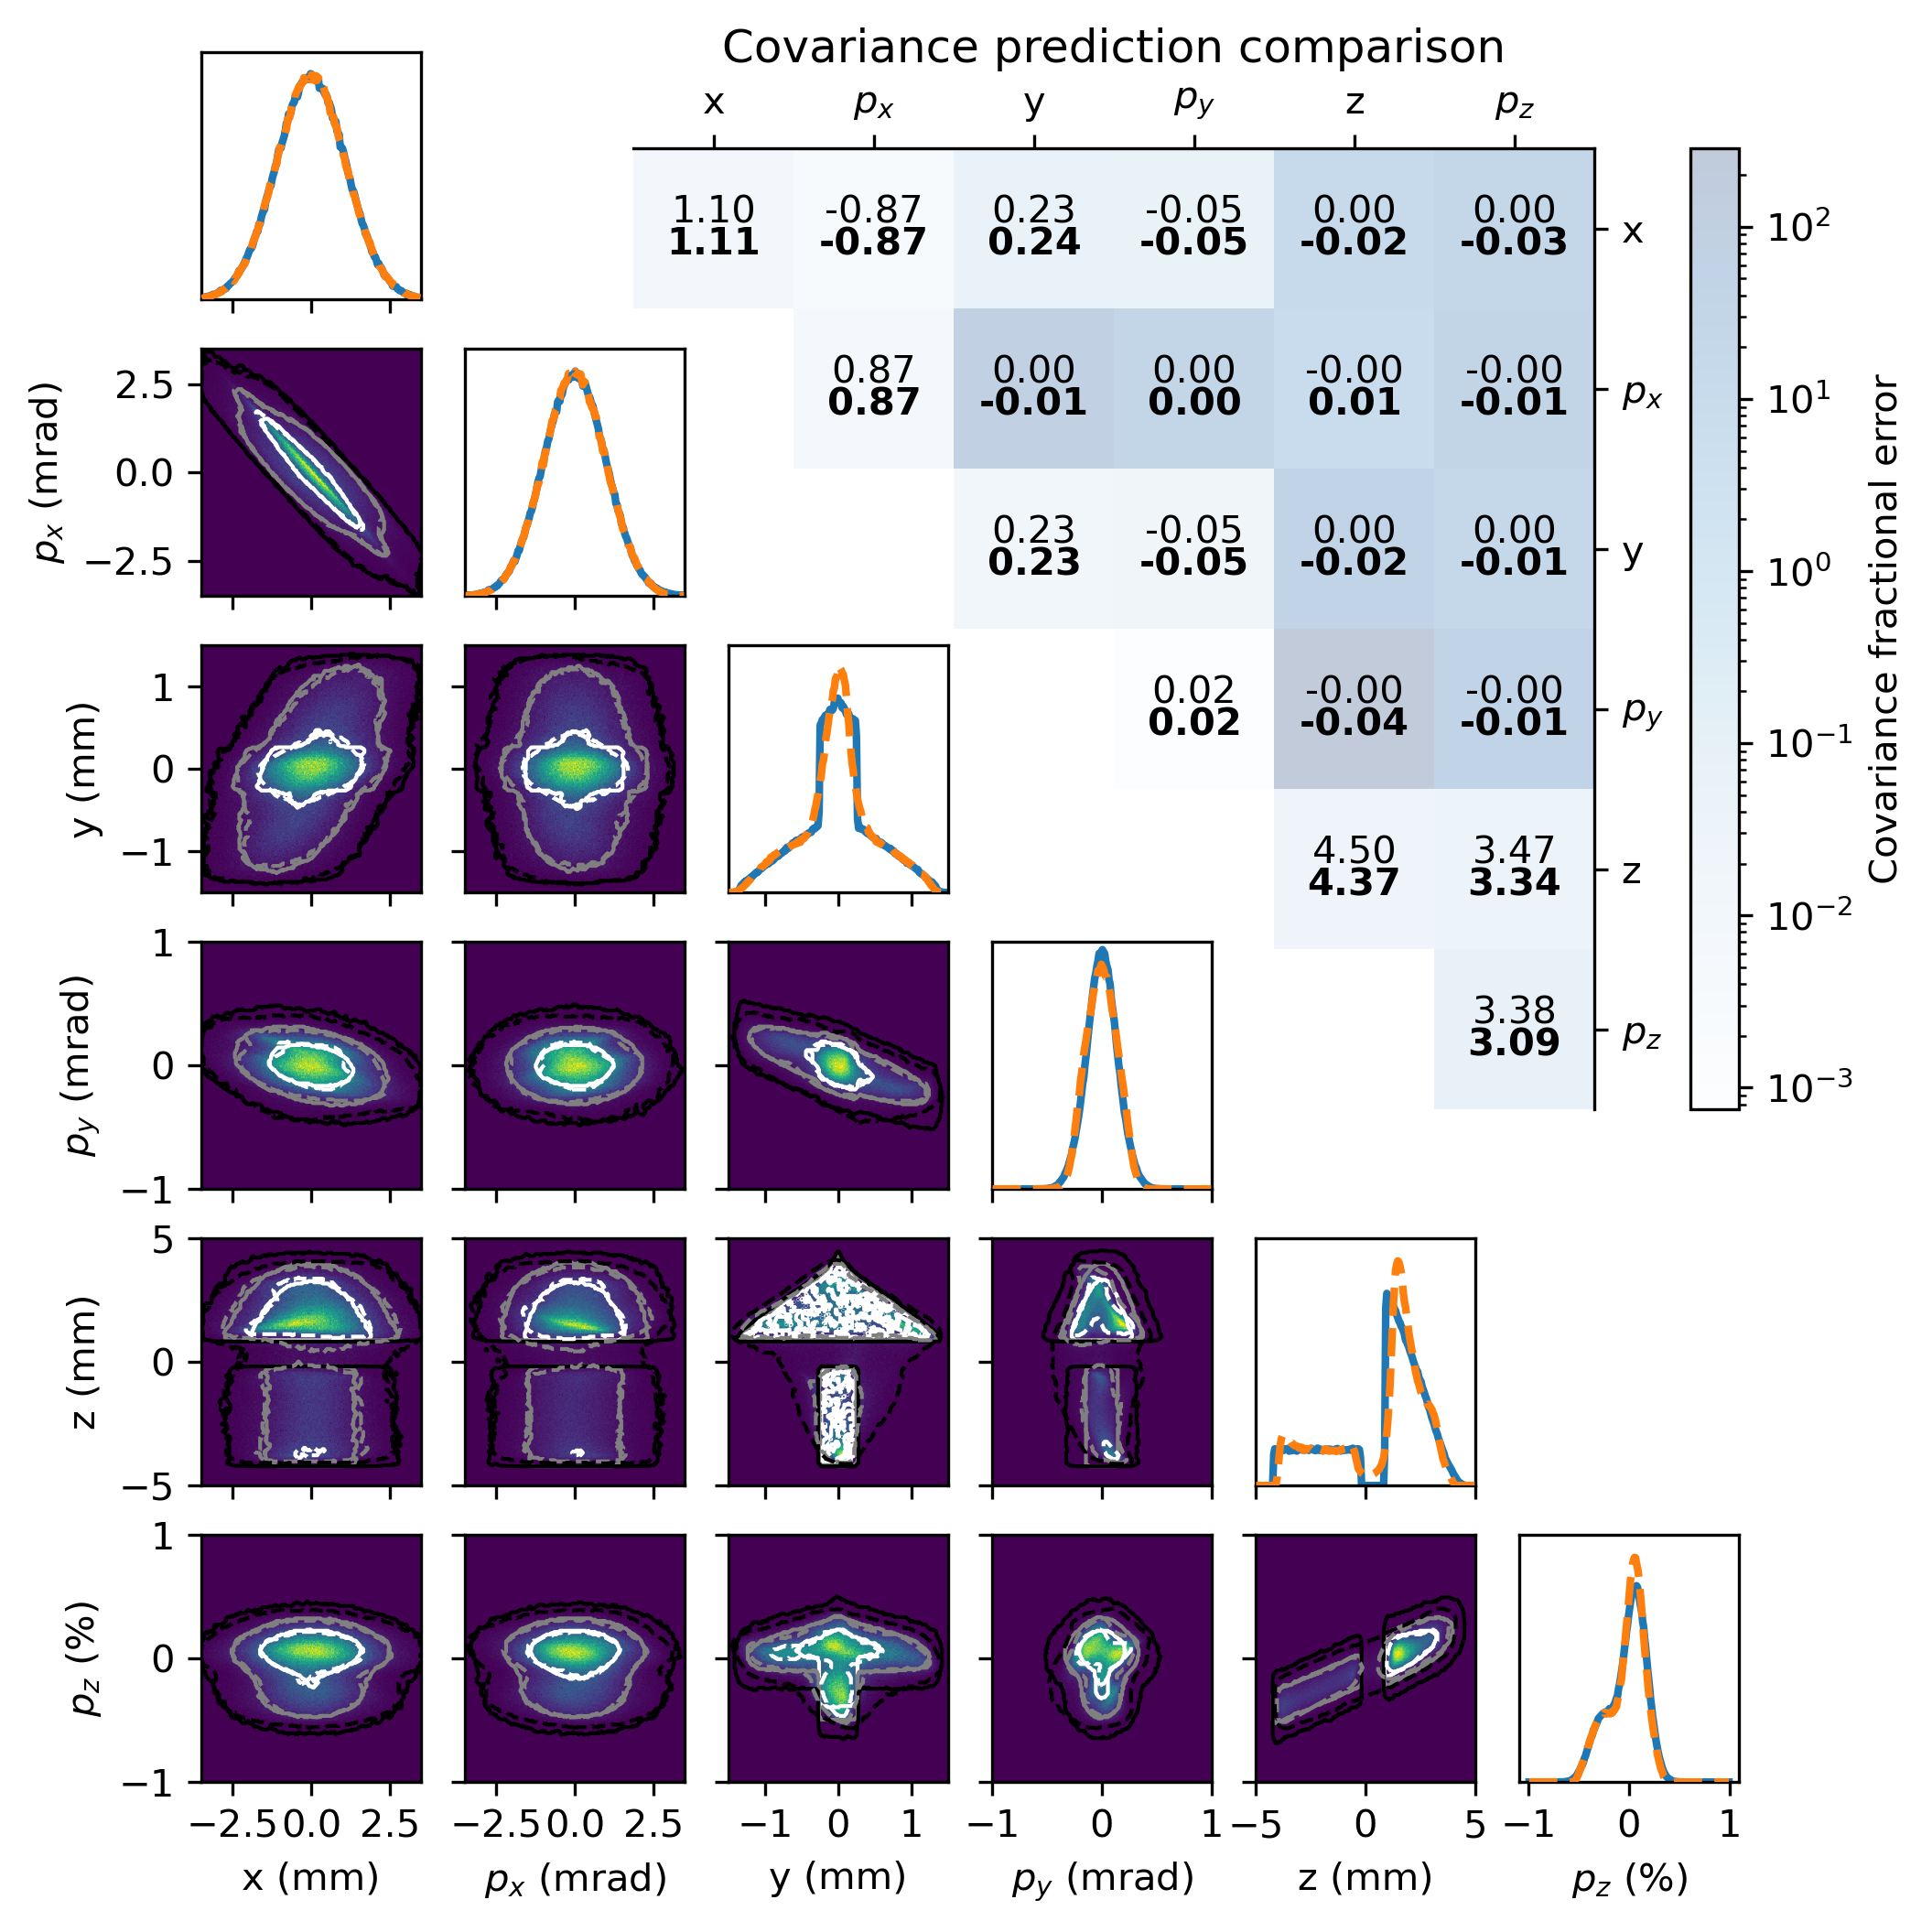

In [4]:
import torch
from stats import plot_prab_figure
import os

recn_dist = torch.load(os.path.join(save_dir, 'dist_3000.pt'))

slims = np.array([[-7, 7],
                 [-7, 7],
                 [-3, 3],
                 [-2, 2],
                 [-10, 10],
                 [-2, 2]])*0.5

fig = plot_prab_figure(
    recn_dist,
    gt_beam,
    n_bins=200,
    contour_percentiles = [50,90,100],
    custom_lims=slims,
    contour_smoothing=0.0,
)
#fig.savefig("eex_reconstruction.svg")